In [10]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html, Input, Output
import tkinter as tk
from tkinter import filedialog

root = tk.Tk()
root.withdraw()

# current_directory = os.getcwd()
# print(f"Current working directory: {current_directory}")

print("Files in current directory:")
for item in os.listdir():
    print(f"  {item}")


Files in current directory:
  .DS_Store
  Requirements-1.txt
  Read me- Data 2.txt
  viration_code2_18.png
  Code 2.ipynb
  statistic_map.png
  Automated track infrastructure recognition using vibration analysis.pdf
  Code 1.ipynb
  data
  Emaint_Bandel_331_Borlänge_Mora_Turnout.xlsx
  map_18_data_2.png


In [11]:
# ====================
# Data Loading using Tkinter
# ====================
  # Hide the root Tk window

# Define file keys for CSV files.

base_path = os.path.join('data', 'data_2', 'Data 2')

print(f"Data path: {base_path}")

try:
    timestamp_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    timestamp_folders.sort() 
    print(f"Found {len(timestamp_folders)} timestamp folders")
    if timestamp_folders:
        print(f"First few folders: {timestamp_folders[:5]}...")
except Exception as e:
    print(f"Error accessing data path: {e}")
    timestamp_folders = []
    
files = {
    "latitude": 'GPS.latitude.csv',
    "longitude": 'GPS.longitude.csv',
    "vibration1": 'CH1_ACCEL1Z1.csv',
    "vibration2": 'CH1_ACCEL1Z2.csv',
    "speed": 'GPS.speed.csv'
}

def load_file(key):
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    print(file_path)
    if file_path:
        files[key] = file_path
        print(f"{key.capitalize()} file loaded: {file_path}")

print("Select Latitude File")
load_file("latitude")
print("Select Longitude File")
load_file("longitude")
print("Select Vibration 1 File")
load_file("vibration1")
print("Select Vibration 2 File")
load_file("vibration2")
print("Select Speed File")
load_file("speed")

# Load each CSV into a DataFrame and add a 'timestamp' using the row index.
dataframes = {}
for key, file_path in files.items():
    if file_path:
        df = pd.read_csv(file_path, header=None, names=[key])
        df['timestamp'] = df.index
        dataframes[key] = df
    else:
        print(f"{key.capitalize()} file not selected.")

Data path: data/data_2/Data 2
Found 139 timestamp folders
First few folders: ['2024-12-08 02-00-00 (1)', '2024-12-08 04-00-00 (1)', '2024-12-08 06-00-00 (1)', '2024-12-08 08-00-00 (1)', '2024-12-08 10-00-00 (1)']...
Select Latitude File
/Users/atefehmirzabeigi/Documents/Documents - Atefeh’s MacBook Air/Master's program/eMaintenance_and_AI/assignment_4/data/data_2/Data 2/2024-12-10 12-00-00 (1)/GPS.latitude.csv
Latitude file loaded: /Users/atefehmirzabeigi/Documents/Documents - Atefeh’s MacBook Air/Master's program/eMaintenance_and_AI/assignment_4/data/data_2/Data 2/2024-12-10 12-00-00 (1)/GPS.latitude.csv
Select Longitude File
/Users/atefehmirzabeigi/Documents/Documents - Atefeh’s MacBook Air/Master's program/eMaintenance_and_AI/assignment_4/data/data_2/Data 2/2024-12-10 12-00-00 (1)/GPS.longitude.csv
Longitude file loaded: /Users/atefehmirzabeigi/Documents/Documents - Atefeh’s MacBook Air/Master's program/eMaintenance_and_AI/assignment_4/data/data_2/Data 2/2024-12-10 12-00-00 (1)/GPS.

In [14]:
# ====================
# Create GPS DataFrame by merging latitude and longitude.
# ====================
if "latitude" in dataframes and "longitude" in dataframes:
    df_gps = pd.merge(dataframes["latitude"], dataframes["longitude"], on="timestamp")
    # Rename columns for consistency
    df_gps = df_gps.rename(columns={"latitude": "Latitude", "longitude": "Longitude"})
    # Add an index column for use in the interactive plot
    df_gps["PointIndex"] = df_gps.index
    
    infrastructure_lat_min = 60.50  # From Code 1 data.describe()
    infrastructure_lat_max = 61.01  # From Code 1 data.describe()
    infrastructure_lon_min = 14.50  # From Code 1 data.describe()
    infrastructure_lon_max = 15.35  # From Code 1 data.describe()

    print("\nCode 1 infrastructure bounds:")
    print(f"Latitude range: {infrastructure_lat_min} to {infrastructure_lat_max}")
    print(f"Longitude range: {infrastructure_lon_min} to {infrastructure_lon_max}")

    print(f"Original GPS points: {len(df_gps)}")
    df_gps_filtered = df_gps[
        (df_gps['Latitude'] >= infrastructure_lat_min) &
        (df_gps['Latitude'] <= infrastructure_lat_max) &
        (df_gps['Longitude'] >= infrastructure_lon_min) &
        (df_gps['Longitude'] <= infrastructure_lon_max)
    ]
    print(f"Filtered GPS points (same track as Code 1): {len(df_gps_filtered)}")
    print(f"Percentage of points kept: {len(df_gps_filtered)/len(df_gps)*100:.2f}%")

    df_gps = df_gps_filtered
    
    # Count duplicates
    
else:
    print("Latitude or Longitude data is missing.")
    df_gps = pd.DataFrame(columns=["Latitude", "Longitude", "PointIndex"])

# to later clean the data I need a copy of the df_gps
df_gps_copy = df_gps.copy()



Code 1 infrastructure bounds:
Latitude range: 60.5 to 61.01
Longitude range: 14.5 to 15.35
Original GPS points: 36000
Filtered GPS points (same track as Code 1): 17765
Percentage of points kept: 49.35%


In [15]:

# ====================
# Merge the two vibration signals on 'timestamp'
# ====================
if "vibration1" in dataframes and "vibration2" in dataframes:
    df_vibration_merged = pd.merge(
        dataframes["vibration1"],
        dataframes["vibration2"],
        on="timestamp"
        # When the column names differ (here: vibration1 vs vibration2), suffixes are not needed.
    )
    # You may rename columns if desired; here they remain "vibration1" and "vibration2"
else:
    print("Vibration data files are missing.")
    df_vibration_merged = pd.DataFrame()
    
# for cleaning the data later I need a copy of the data. 
df_vibration_merged_copy = df_vibration_merged.copy()
# ====================
# Data Preprocessing and Segmentation for Vibration Data
# ====================
dt_vibration = 0.002  # seconds per sample (e.g. 500 Hz sampling rate)
segment_duration_seconds = 10
segment_length = int(segment_duration_seconds / dt_vibration)
if not df_vibration_merged.empty:
    num_segments = len(df_vibration_merged) // segment_length
    segments = []
    for i in range(num_segments):
        seg = df_vibration_merged.iloc[i * segment_length: (i + 1) * segment_length][["vibration1", "vibration2"]].values
        segments.append(seg)
    segments = np.array(segments)
    print("Segmented vibration data shape:", segments.shape)
else:
    segments = np.array([])
    print("No vibration data available for segmentation.")

# ====================
# Build the Interactive Dash App
# ====================

# Create the interactive GPS map using Plotly Express.
if not df_gps.empty:
    # Use custom_data to store the point index so that it will be available in callbacks.
    map_fig = px.scatter_mapbox(
        df_gps,
        lat="Latitude",
        lon="Longitude",
        custom_data=["PointIndex"],
        zoom=10,
        title="GPS Points with Vibration Data"
    )
    map_fig.update_layout(mapbox_style="open-street-map", height=600)
else:
    map_fig = go.Figure()
    map_fig.update_layout(title="No GPS Data Available", height=600)

# Create an initial empty vibration plot figure.
vib_empty_fig = go.Figure()
vib_empty_fig.update_layout(
    title="Vibration Signal",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration"
)

# Initialize Dash app.
app = dash.Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Graph(id="gps-map", figure=map_fig)
    ], style={'width': '48%', 'display': 'inline-block', 'vertical-align': 'top'}),
    html.Div([
        dcc.Graph(id="vibration-plot", figure=vib_empty_fig)
    ], style={'width': '48%', 'display': 'inline-block', 'vertical-align': 'top'})
])

# --------------------
# Callback to Update the Vibration Plot Based on Clicked GPS Point
# --------------------
@app.callback(
    Output('vibration-plot', 'figure'),
    [Input('gps-map', 'clickData')]
)
def update_vibration_plot(clickData):
    # If no point is selected, return the empty vibration figure.
    if clickData is None:
        return vib_empty_fig

    # Retrieve the selected GPS point index from custom_data.
    # point_index = clickData['points'][0]['customdata'][0]
    if 'customdata' in clickData['points'][0]:
        point_index = clickData['points'][0]['customdata'][0]
    else:
        # Use pointIndex as fallback
        point_index = clickData['points'][0]['pointIndex']
        print(f"Using pointIndex as fallback: {point_index}")
    
    if segments.size == 0:
        empty_fig = go.Figure()
        empty_fig.update_layout(
            title="No Vibration Data Available",
            xaxis_title="Time (s)",
            yaxis_title="Acceleration"
        )
        return empty_fig

    # Map the GPS point to a vibration segment. If the selected index exceeds
    # the available number of segments, use the last segment as fallback.
    if point_index < segments.shape[0]:
        selected_segment = segments[point_index]
    else:
        selected_segment = segments[-1]

    # Create a time axis for the selected segment.
    time_axis = np.arange(segment_length) * dt_vibration

    vib_fig = go.Figure()
    vib_fig.add_trace(go.Scatter(
        x=time_axis,
        y=selected_segment[:, 0],
        mode='lines',
        name='Vibration Channel 1'
    ))
    vib_fig.add_trace(go.Scatter(
        x=time_axis,
        y=selected_segment[:, 1],
        mode='lines',
        name='Vibration Channel 2'
    ))
    vib_fig.update_layout(
        title=f"Vibration Signal for GPS Point {point_index}",
        xaxis_title="Time (s)",
        yaxis_title="Acceleration"
    )
    return vib_fig

# ====================
# Run the Dash App
# ====================
if __name__ == "__main__":
    app.run(debug=True, port=8060)

Segmented vibration data shape: (7199, 5000, 2)


/var/folders/k6/2q6mh7z1637fmlm2vm3bp5sh0000gn/T/ipykernel_23021/128578431.py:43: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Using pointIndex as fallback: 15351
Using pointIndex as fallback: 2739
Using pointIndex as fallback: 14835
Using pointIndex as fallback: 12969
Using pointIndex as fallback: 14417


In [16]:
print(dataframes.keys())
print(f"GPS DataFrame shape: {df_gps_copy.shape}")
print(f"Vibration DataFrame shape: {df_vibration_merged_copy.shape}")

df_gps_copy.info()
df_vibration_merged_copy.info()

dict_keys(['latitude', 'longitude', 'vibration1', 'vibration2', 'speed'])
GPS DataFrame shape: (17765, 4)
Vibration DataFrame shape: (35999958, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 17765 entries, 0 to 35999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Latitude    17765 non-null  float64
 1   timestamp   17765 non-null  int64  
 2   Longitude   17765 non-null  float64
 3   PointIndex  17765 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 693.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35999958 entries, 0 to 35999957
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   vibration1  float64
 1   timestamp   int64  
 2   vibration2  float64
dtypes: float64(2), int64(1)
memory usage: 824.0 MB


In [ ]:
 

duplicate_count_gps = df_gps_copy.duplicated(subset=['Latitude', 'Longitude']).sum()
print("Duplicate check in GPS data", duplicate_count_gps)
if duplicate_count_gps > 0:
    df_gps_clean = df_gps_copy.drop_duplicates(subset=['Latitude', 'Longitude'])
    print(f"GPS dataframe shape after removing duplicates: {df_gps_clean.shape}")
else:
    df_gps_clean = df_gps_copy

df_gps_nan = df_gps_copy.isnull().sum()
print("NaN values in GPS data:", df_gps_nan)

if df_gps_nan.any():
    df_gps_clean = df_gps_copy.dropna() 
    print("GPS dataframe shape after filling NaN values:", df_gps_clean.shape)

else:
    df_gps_clean = df_gps_copy




Duplicate check in GPS data 1715
GPS dataframe shape after removing duplicates: (16050, 4)
NaN values in GPS data: Latitude      0
timestamp     0
Longitude     0
PointIndex    0
dtype: int64


Found 564 outliers using DBSCAN


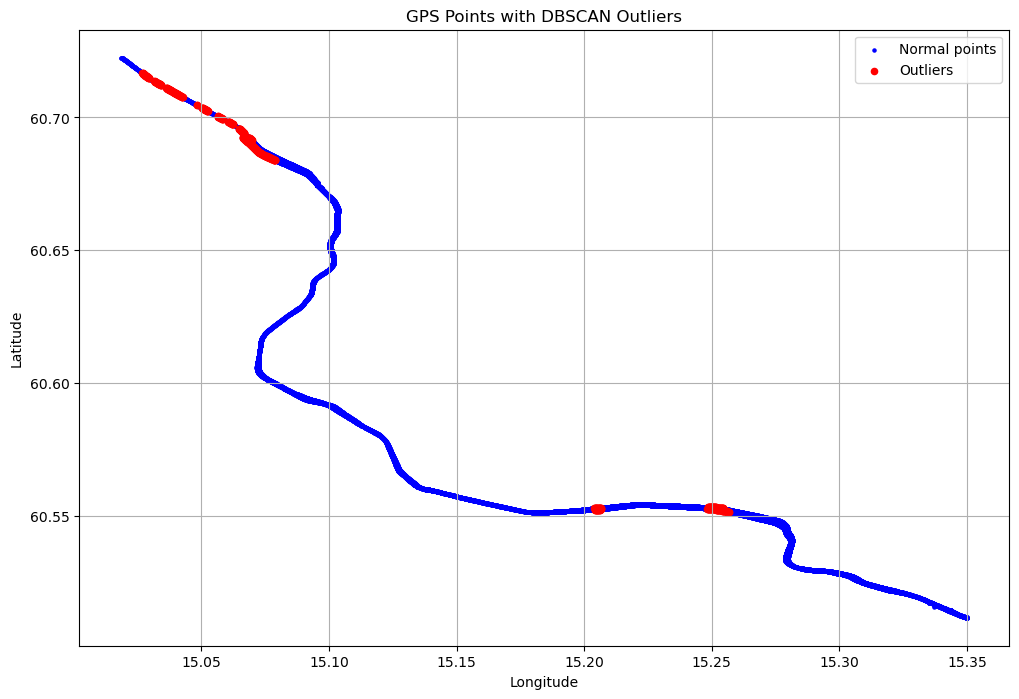

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

coords = df_gps_clean[['Latitude', 'Longitude']].values

coords_scaled = StandardScaler().fit_transform(coords)

dbscan = DBSCAN(eps=0.011, min_samples=20).fit(coords_scaled)
labels = dbscan.labels_

outlier_mask = labels == -1
outliers = df_gps_clean[outlier_mask]
print(f"Found {len(outliers)} outliers using DBSCAN")

plt.figure(figsize=(12, 8))
plt.scatter(
    df_gps_clean.loc[~outlier_mask, 'Longitude'], 
    df_gps_clean.loc[~outlier_mask, 'Latitude'], 
    c='blue', s=5, label='Normal points'
)
plt.scatter(
    df_gps_clean.loc[outlier_mask, 'Longitude'], 
    df_gps_clean.loc[outlier_mask, 'Latitude'], 
    c='red', s=20, label='Outliers'
)
plt.title('GPS Points with DBSCAN Outliers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

In [60]:

data_path_1 = os.path.join('data/data_1')

files = {
    "Bridge": os.path.join(data_path_1, "converted_coordinates_Resultat_Bridge.csv"),
    "RailJoint": os.path.join(data_path_1, "converted_coordinates_Resultat_RailJoint.csv"), 
    "Turnout": os.path.join(data_path_1, "converted_coordinates_Turnout.csv")
}


data_frames = []
for category, file in files.items():
    try:
        df = pd.read_csv(file, encoding="utf-8")  # Load CSV with UTF-8 encoding
        df.columns = df.columns.str.strip()  # Strip column names of extra spaces
        if "Latitude" in df.columns and "Longitude" in df.columns:
            df["Latitude"] = pd.to_numeric(df["Latitude"], errors="coerce")  # Convert Latitude to numeric
            df["Longitude"] = pd.to_numeric(df["Longitude"], errors="coerce")  # Convert Longitude to numeric
            df = df[["Latitude", "Longitude"]]  # Select necessary columns
            df["Category"] = category  # Add category column
            data_frames.append(df)
            print(f"Successfully loaded {category} data: {len(df)} rows")
        else:
            print(f"Warning: {category} file does not contain 'Latitude' and 'Longitude' columns.")
            print(f"Available columns: {df.columns.tolist()}")
    except Exception as e:
        print(f"Error loading {category}: {e}")

# Combine all data
if data_frames:
    data = pd.concat(data_frames, ignore_index=True)
else:
    raise ValueError("No valid data found. Check your CSV files.")

print(data.head())
# split the data into 70 percent for training and 30 percent for testing
train_data = (data.sample(frac=0.7, random_state=42))
test_data = data.drop(train_data.index)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

x_train  = train_data.drop(columns=['Category'])
y_train = train_data['Category']

x_test = test_data.drop(columns=['Category'])
y_test = test_data['Category']


Successfully loaded Bridge data: 25 rows
Successfully loaded RailJoint data: 20 rows
Successfully loaded Turnout data: 75 rows
    Latitude  Longitude Category
0  60.529364  15.295477   Bridge
1  60.535942  15.280320   Bridge
2  60.540823  15.281730   Bridge
3  60.559659  15.140536   Bridge
4  60.668396  15.101613   Bridge
Train data shape: (84, 3)
Test data shape: (36, 3)


Classification Report:
              precision    recall  f1-score   support

      Bridge       0.12      0.17      0.14         6
   RailJoint       0.36      1.00      0.53         4
     Turnout       0.82      0.54      0.65        26

    accuracy                           0.53        36
   macro avg       0.44      0.57      0.44        36
weighted avg       0.66      0.53      0.55        36

Confusion Matrix:
[[ 1  2  3]
 [ 0  4  0]
 [ 7  5 14]]
Using 17201 cleaned points for classification


/Users/atefehmirzabeigi/miniconda3/envs/tif345_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names




Classification Results Summary:
Infrastructure_Type
Other        13122
RailJoint     4079
Name: count, dtype: int64

Confidence Statistics:
Mean confidence: 0.6627
Min confidence: 0.4036
Max confidence: 0.7632


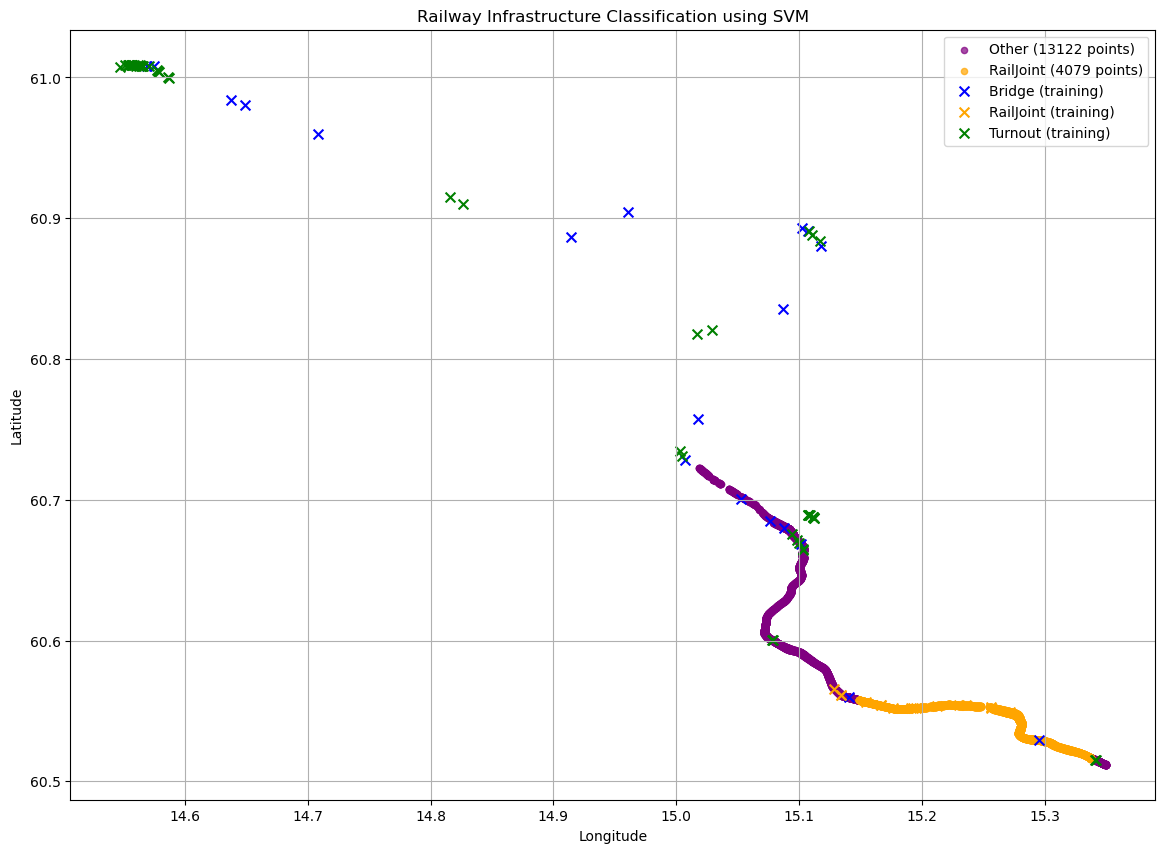

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)


model = svm.SVC(kernel='rbf',     
               C=1.0,            
               gamma='scale',   
               probability=True,
               class_weight='balanced')

model.fit(X_train_scaled, y_train)

x_test_scaled = scaler.transform(x_test)
y_pred = model.predict(x_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


df_clean_railway = df_gps_clean[~outlier_mask].copy().reset_index(drop=True)
print(f"Using {len(df_clean_railway)} cleaned points for classification")

X_classify = df_clean_railway[['Latitude', 'Longitude']].values
X_classify_scaled = scaler.transform(X_classify)

railway_predictions = model.predict(X_classify_scaled)
prediction_probabilities = model.predict_proba(X_classify_scaled)

confidence_values = np.max(prediction_probabilities, axis=1)

confidence_threshold = 0.7
df_clean_railway['Infrastructure_Type'] = railway_predictions


df_clean_railway.loc[confidence_values < confidence_threshold, 'Infrastructure_Type'] = 'Other'

# Store the confidence values
df_clean_railway['Confidence'] = confidence_values

print("\nClassification Results Summary:")
print(df_clean_railway['Infrastructure_Type'].value_counts())

print("\nConfidence Statistics:")
print(f"Mean confidence: {df_clean_railway['Confidence'].mean():.4f}")
print(f"Min confidence: {df_clean_railway['Confidence'].min():.4f}")
print(f"Max confidence: {df_clean_railway['Confidence'].max():.4f}")


plt.figure(figsize=(14, 10))

categories = df_clean_railway['Infrastructure_Type'].unique()

color_map = {
    'Bridge': 'blue',
    'RailJoint': 'orange',
    'Turnout': 'green',
    'Other': 'purple'  
}

default_colors = ['orange', 'cyan', 'magenta', 'yellow']

for i, category in enumerate(categories):
    category_data = df_clean_railway[df_clean_railway['Infrastructure_Type'] == category]
    
    if category in color_map:
        color = color_map[category]
    else:
        color = default_colors[i % len(default_colors)]
        
    plt.scatter(
        category_data['Longitude'],
        category_data['Latitude'],
        c=color,
        label=f'{category} ({len(category_data)} points)',
        alpha=0.7,
        s=20
    )

for i, category in enumerate(np.unique(y_train)):
    category_data = x_train[y_train == category]
    
    if category in color_map:
        color = color_map[category]
    else:
        color = default_colors[i % len(default_colors)]
        
    plt.scatter(
        category_data['Longitude'],
        category_data['Latitude'],
        c=color,
        marker='x',
        s=50,
        label=f'{category} (training)',
        alpha=1.0
    )

plt.title('Railway Infrastructure Classification using SVM')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

Total GPS points: 17201
Infrastructure points (Bridge, RailJoint, Turnout): 4079
Points removed: 13122

Labeling 7199 vibration segments with infrastructure types

Vibration Segment Label Distribution:
  Other: 5230 segments (72.6%)
  RailJoint: 1969 segments (27.4%)

Vibration Segment Label Distribution:
  Other: 5230 segments (72.6%)
  RailJoint: 1969 segments (27.4%)


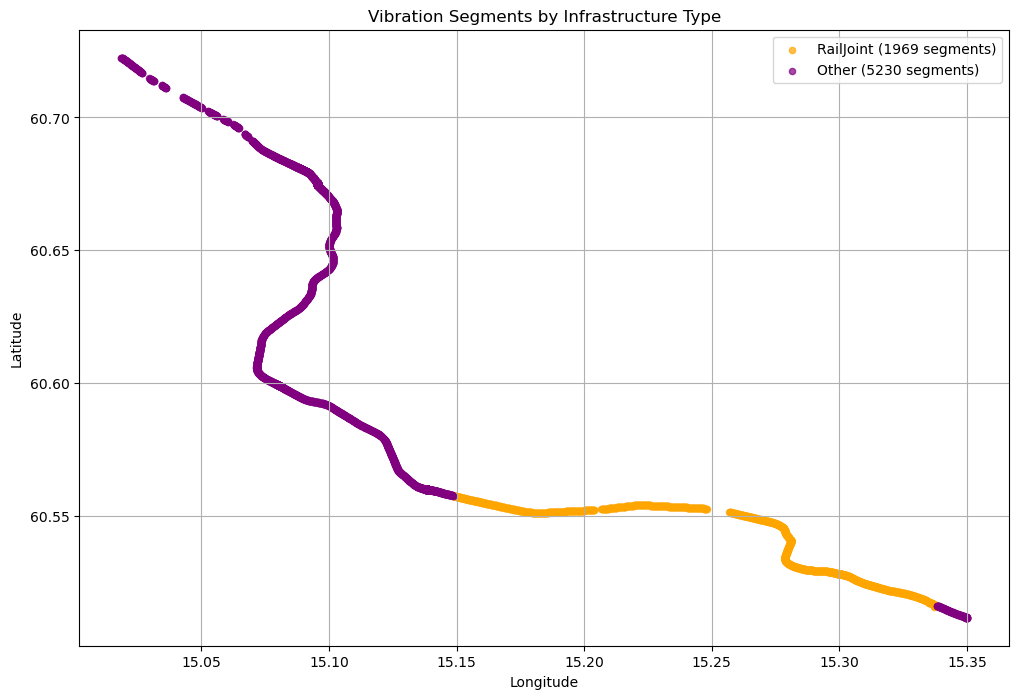

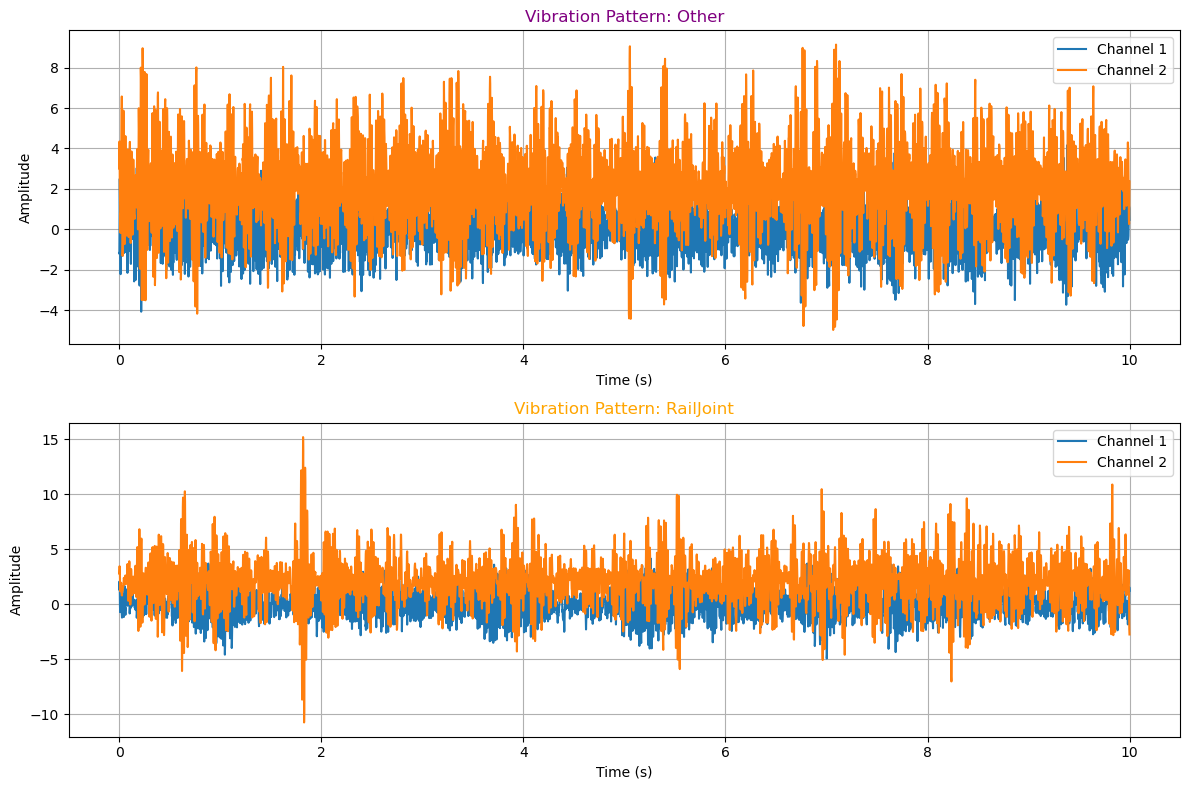


Task completed successfully:
1. Filtered to keep only infrastructure points
2. Labeled all vibration segments with corresponding infrastructure types
3. Created 7199 labeled vibration segments for analysis


In [71]:
infrastructure_types = ['Bridge', 'RailJoint', 'Turnout']
df_infrastructure_only = df_clean_railway[df_clean_railway['Infrastructure_Type'].isin(infrastructure_types)].copy()

print(f"Total GPS points: {len(df_clean_railway)}")
print(f"Infrastructure points (Bridge, RailJoint, Turnout): {len(df_infrastructure_only)}")
print(f"Points removed: {len(df_clean_railway) - len(df_infrastructure_only)}")

labeled_segments = []
segment_labels = []

if segments.size > 0:
    max_segments = min(len(segments), len(df_clean_railway))
    
    print(f"\nLabeling {max_segments} vibration segments with infrastructure types")
    
    for i in range(max_segments):
        if i < len(df_clean_railway):
            infra_type = df_clean_railway.iloc[i]['Infrastructure_Type']
            
            if infra_type not in infrastructure_types:
                infra_type = "Other"
                
            labeled_segments.append({
                'segment_id': i,
                'vibration_data': segments[i],
                'infrastructure_type': infra_type,
                'latitude': df_clean_railway.iloc[i]['Latitude'],
                'longitude': df_clean_railway.iloc[i]['Longitude']
            })
            
            segment_labels.append(infra_type)
    
    unique_labels, counts = np.unique(segment_labels, return_counts=True)
    
    print("\nVibration Segment Label Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  {label}: {count} segments ({count/len(segment_labels)*100:.1f}%)")
    
    segments_df = pd.DataFrame({
        'segment_id': range(len(labeled_segments)),
        'infrastructure_type': segment_labels,
        'latitude': [seg['latitude'] for seg in labeled_segments],
        'longitude': [seg['longitude'] for seg in labeled_segments]
    })
    
    color_map = {
        'Bridge': 'blue',
        'RailJoint': 'orange',
        'Turnout': 'green',
        'Other': 'purple'  
    }
    
    plt.figure(figsize=(12, 8))
    
    for category in ['Bridge', 'RailJoint', 'Turnout', 'Other']:
        if category in segments_df['infrastructure_type'].values:
            category_data = segments_df[segments_df['infrastructure_type'] == category]
            color = color_map.get(category, 'gray')  # Use gray as fallback color
            plt.scatter(
                category_data['longitude'],
                category_data['latitude'],
                c=color,
                label=f'{category} ({len(category_data)} segments)',
                alpha=0.7,
                s=20
            )
    
    plt.title('Vibration Segments by Infrastructure Type')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    example_vibrations = {}
    
    for category in np.unique(segment_labels):
        category_segments = [seg for seg in labeled_segments if seg['infrastructure_type'] == category]
        if category_segments:
            example_vibrations[category] = category_segments[0]['vibration_data']
    
    time_axis = np.arange(segments[0].shape[0]) * dt_vibration
    
    fig, axes = plt.subplots(len(example_vibrations), 1, figsize=(12, 4*len(example_vibrations)))
    
    if len(example_vibrations) == 1:
        axes = [axes]
    
    for i, (category, vibration_data) in enumerate(example_vibrations.items()):
        axes[i].plot(time_axis, vibration_data[:, 0], label='Channel 1')
        axes[i].plot(time_axis, vibration_data[:, 1], label='Channel 2')
        
        color = color_map.get(category, 'black')
        axes[i].set_title(f'Vibration Pattern: {category}', color=color)
        
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTask completed successfully:")
    print("1. Filtered to keep only infrastructure points")
    print("2. Labeled all vibration segments with corresponding infrastructure types")
    print(f"3. Created {len(labeled_segments)} labeled vibration segments for analysis")
else:
    print("No vibration segments available for labeling")